In [1]:
%load_ext autoreload 
%autoreload 2


In [2]:
import mitsuba as mi
mi.set_variant("cuda_ad_rgb")

[mitsuba] Warning: Couldn't import the ipywidgets package. Installing this package is required for the system to properly log messages and print in Jupyter notebooks!


In [3]:
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from tqdm.cli import tqdm

# Input Data

Two crops of 2nd-6th fuel rod from One-Image-Overview(OIO):
* Fresh
* Used - around a year old
* Gone - at the end of its lifetime

All are made of the same material, same camera setup. Notice that the older material is, the more irregular spots appear making the inverse rendering hard.

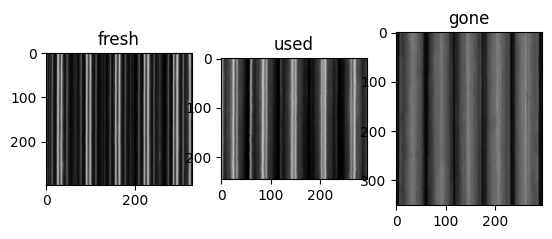

In [4]:
fresh_path = Path('/home/knotek/fresh.png')
used_path = Path('/home/knotek/used.png')
gone_path = Path('/home/knotek/gone.png')

paths = [fresh_path,used_path,gone_path]
imgs = [imageio.imread(p)[:,:,0]/255 for p in paths]

fresh_img, used_img, gone_img = imgs

_,axs = plt.subplots(1,3)

for ax,p,img in zip(axs,paths,imgs):
    ax.imshow(img,cmap='gray',vmin=0,vmax=1)
    ax.set_title(p.stem)
plt.show()

# Scene


Nuclear Fuel Assembly (FA) has a hexagonal footprint with rods 9.1mm wide with 3.65 gap between. There are 11 rods per face.

NOTE: The plot show only one camera even thoug in reality there are three - each recording every other face. 


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


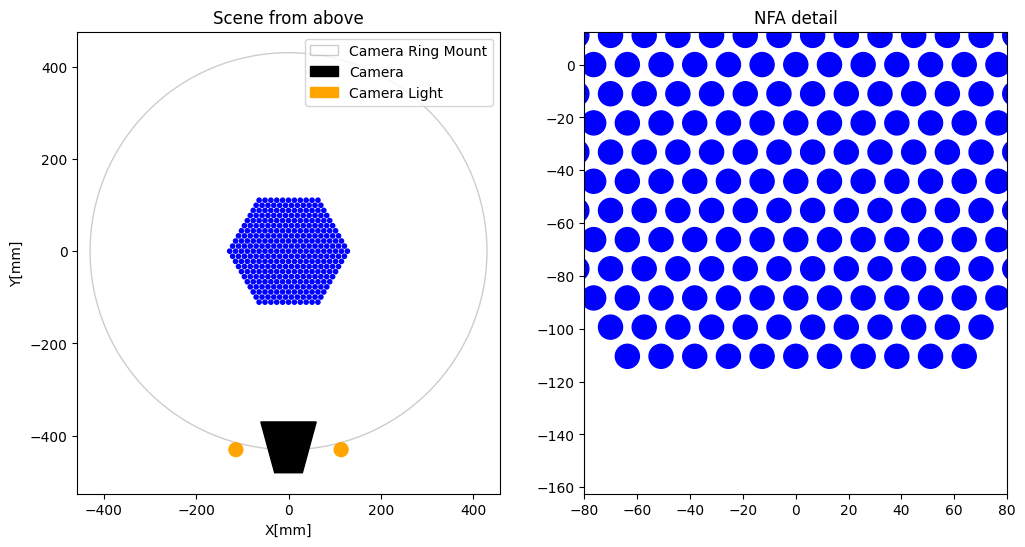

In [13]:
from synthnf.config.defaults import blueprints as bl
import synthnf.geometry.fuel_rods_mesh as frm

RODS_PER_FACE = 11
ROD_DIAMETER_MM = 9.1
ROD_GAP_MM = 3.65


def plot_lights(ax, light_radius,ring_diameter,light_offset):
    
    cam_light_left = plt.Circle(
        [-light_offset/2,-ring_diameter/2],
        radius = light_radius *3, # *3 to make it more visible
        color = 'orange',
        label = "Camera Light"
    )
    
    cam_light_right = plt.Circle(
        [light_offset/2,-ring_diameter/2],
        radius = light_radius*3,
        color = 'orange',
    )
    ax.add_patch(cam_light_left)
    ax.add_patch(cam_light_right)

def plot_camera(ax,ring_diameter):

    cam_ring = plt.Circle(
        (0, 0), 
        ring_diameter/2, 
        color='black', 
        fill=False,
        alpha = .2,
        label='Camera Ring Mount'
    )

    move_down = [0, ring_diameter/2]
    cam_poly = np.array([[-60,60],[60,60],[30,-50],[-30,-50]]) - move_down
    
    cam_box = plt.Polygon(
        cam_poly,
        edgecolor ='black',
        facecolor = 'black',
        label='Camera'
    )

    ax.add_patch(cam_ring)
    ax.add_patch(cam_box)
    

def plot_rods(ax,n_rods,rods_width_mm,rods_gaps_mm):
    rcs = frm.generate_rod_centers(n_rods,rods_width_mm,rods_gaps_mm)

    for x,y in rcs:
        rod = plt.Circle(
            (x,y),
            radius = rods_width_mm/2,
            color = 'blue',
        )
        ax.add_patch(rod)
    

ring_diameter = bl.camera_ring.diameter_mm
light_offset = bl.camera_ring.light_offset_mm
diameter_padded =  ring_diameter/2 * 1.2
camera_position = [0,ring_diameter/2,0]

light_radius = bl.camera_ring.light_diameter_mm/2

_,(ax,axx) = plt.subplots(1,2,figsize = (12,6))

plot_rods(ax, RODS_PER_FACE, ROD_DIAMETER_MM, ROD_GAP_MM)
plot_camera(ax,ring_diameter)
plot_lights(ax,light_radius,ring_diameter,light_offset)

ax.set_xlim((-diameter_padded, diameter_padded))
ax.set_ylim((-diameter_padded, diameter_padded))

ax.set_xlabel("X[mm]")
ax.set_ylabel("Y[mm]")
ax.axis('equal')
ax.set_title("Scene from above")

plot_rods(axx, RODS_PER_FACE, ROD_DIAMETER_MM, ROD_GAP_MM)
axx.axis('equal')
axx.set_title("NFA detail")
axx.set_xlim((-80, 80))
axx.set_ylim((-150, 0))
ax.legend()

In [6]:
import synthnf.scene as scene

In [7]:
cam_distance = ring_diameter/2
camera = scene.cam_perspective_lookat(
    [0, cam_distance, 20],
    target = [0,0,0],
    res_y=600,
    res_x=750
)

default_high_contrast_material = {
    'type': 'diffuse',
    'reflectance': {
        'type': 'rgb',
        'value': [1, 0, 1]
    }
}

default_scene = {
    "type": "scene",
    "integrator": {"type": "path"},
    "sensor":camera,
    "light": {
        "type": "constant",
        'radiance': {
            'type': 'rgb',
            'value': 1
        }
     },
}

Generating different oxidation levels: 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


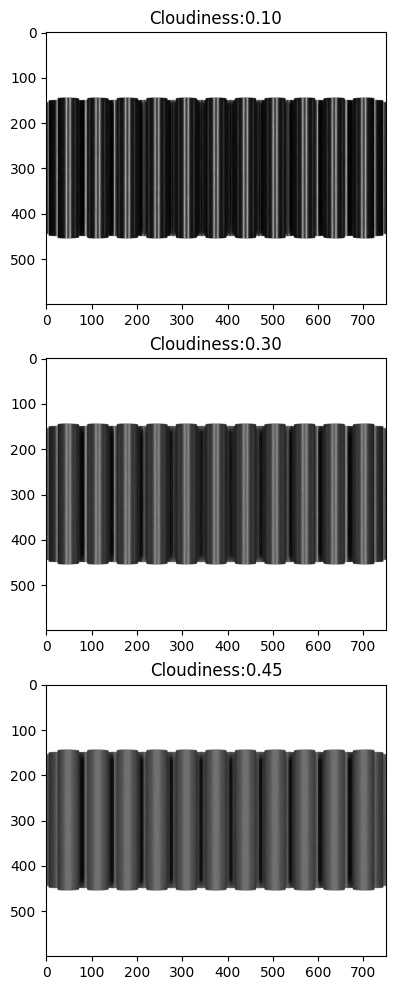

In [8]:
import synthnf.materials.textures as textures
import synthnf.scene as scene
import synthnf.materials as mat
import synthnf.config.defaults as defaults
import synthnf.config.assets as assets

def compose_scene_rod_piece_real_param(
    cam_ligth_intensity = 20,
    light_height = 100,
    cloudiness = .5,
    uv = .1
):
    scene_dict = default_scene.copy()
    material = mat.zirconium_blend(cloudiness=cloudiness,alpha_u=uv,alpha_v=uv)    

    rcs = frm.generate_rod_centers(RODS_PER_FACE, ROD_DIAMETER_MM, ROD_GAP_MM)
    
    first_row = np.arange(0,14)
    second_row = np.arange(57,73)
    third_row = np.arange(111,126) 
    third_res = np.arange(159,163)
    idcs = np.concatenate([first_row,second_row, third_row,third_res])

    
    for i,(x,y) in enumerate(rcs[idcs]):
        fr = {        
            'type': 'cylinder',
            'radius': ROD_DIAMETER_MM/2,
            'p0':[x,y,30],
            'p1':[x,y,-30],
            'material': material
        }

        scene_dict[f'model_{i}']= fr
        
    
    scene_dict['sensor'] = scene.cam_perspective_lookat(
        [0, cam_distance, 0],
        target = [0,0,0],
        res_y=600,
        res_x=750,
        fov=25.88
    )
    scene_dict['light'] = scene.create_mount_emmiter(
        [-light_offset/2,cam_distance,0],
        cam_ligth_intensity,
        light_height_mm=light_height
    )
    scene_dict['light_1'] = scene.create_mount_emmiter(
        [light_offset/2,cam_distance,0],
        cam_ligth_intensity,
        light_height_mm=light_height
    )
    return scene_dict
    
rod_imgs = []

cloudiness = [.1,.3,.45]
uvs = [0.058,0.12,0.28]
mi.set_log_level(mi.LogLevel.Error)
for i,uv in tqdm(zip(cloudiness,uvs), desc= "Generating different oxidation levels",total = len(uvs)):
    scene_dict = compose_scene_rod_piece_real_param(
        cloudiness=i,
        light_height=500,
        cam_ligth_intensity=100,
        uv=uv,
    )
    scene_img = scene.render_scene(scene_dict,denoise = True)
    rod_imgs.append(scene_img)

fig,axs = plt.subplots(len(rod_imgs),1,figsize=(12,4*len(rod_imgs)))
for ax,img,i in zip(axs,rod_imgs,cloudiness):
    ax.imshow(img)
    ax.set_title(f"Cloudiness:{i:.2f}")

plt.show()

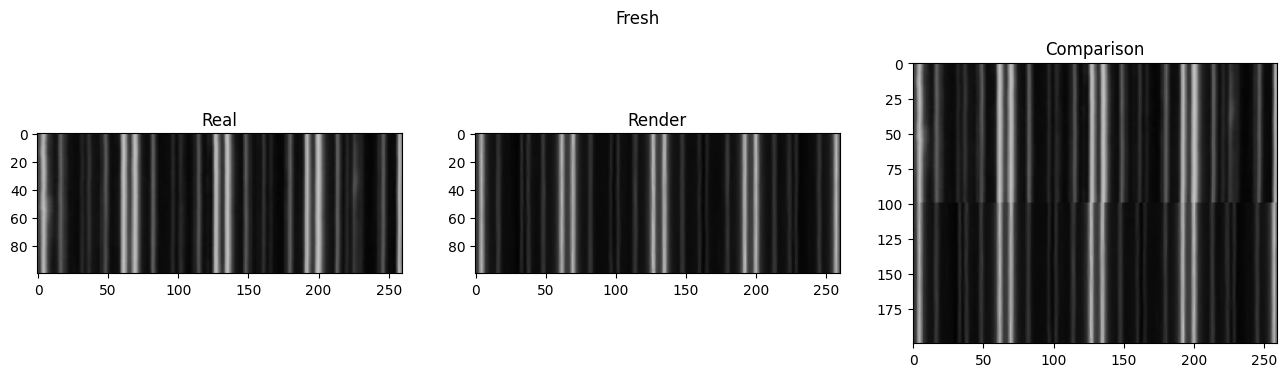

In [9]:
fresh_crop = fresh_img[:,30:290][-100:]

start = 244
width = fresh_crop.shape[1]
render_crop = rod_imgs[0][:,start:start+width][200:300,:,0]
render_crop = render_crop
joined = np.vstack([fresh_crop,render_crop])

_,(ax_real,ax_render,ax_joined) = plt.subplots(1,3,figsize= (16,4))
plt.suptitle("Fresh")

ax_real.imshow(fresh_crop,cmap='gray',vmin=0,vmax=1)
ax_real.set_title("Real")

ax_render.imshow(render_crop,cmap='gray',vmin=0,vmax=1)
ax_render.set_title("Render")

ax_joined.imshow(joined,cmap='gray',vmin=0,vmax=1)
ax_joined.set_title("Comparison")
plt.show()

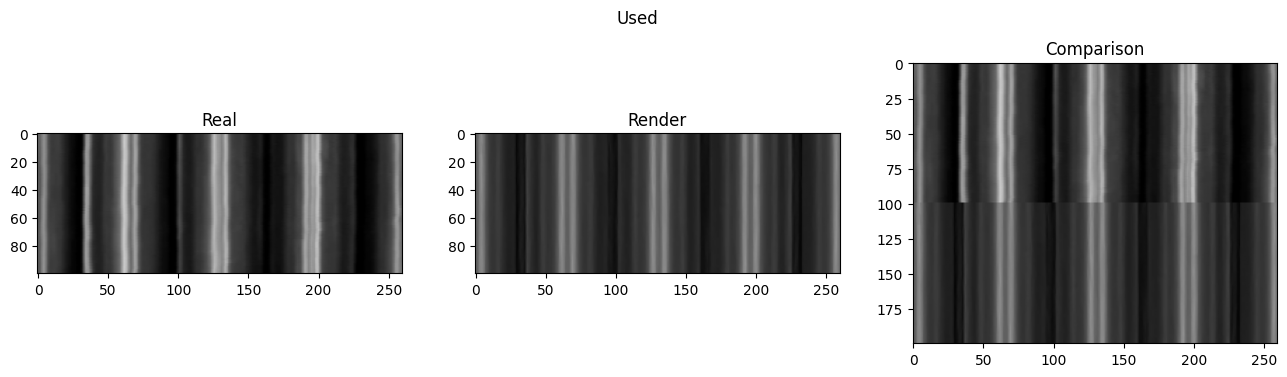

In [14]:
from skimage.transform import resize

used_crop = resize(used_img[:100,28:267],(100,width))

width = used_crop.shape[1]
render_crop = rod_imgs[1][:,start:start+width][200:300,:,0]
render_crop = render_crop

used_joined = np.vstack([used_crop,render_crop])

_,(ax_real,ax_render,ax_joined) = plt.subplots(1,3,figsize= (16,4))
plt.suptitle("Used")

ax_real.imshow(used_crop,cmap='gray',vmin=0,vmax=1)
ax_real.set_title("Real")

ax_render.imshow(render_crop,cmap='gray',vmin=0,vmax=1)
ax_render.set_title("Render")

ax_joined.imshow(used_joined,cmap='gray',vmin=0,vmax=1)
ax_joined.set_title("Comparison")
plt.show()

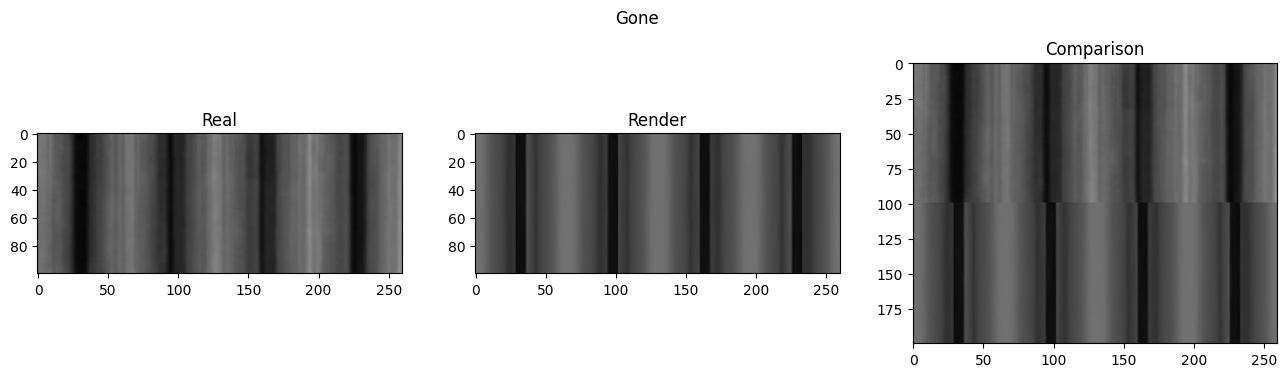

In [15]:
gone_crop = resize(gone_img[:100,33:-32],(100,width))

width = gone_crop.shape[1]
render_crop = rod_imgs[2][:,start:start+width][200:300,:,0]
render_crop = render_crop

joined_gone = np.vstack([gone_crop,render_crop])

_,(ax_real,ax_render,ax_joined) = plt.subplots(1,3,figsize= (16,4))
plt.suptitle("Gone")

ax_real.imshow(gone_crop,cmap='gray',vmin=0,vmax=1)
ax_real.set_title("Real")

ax_render.imshow(render_crop,cmap='gray',vmin=0,vmax=1)
ax_render.set_title("Render")

ax_joined.imshow(joined_gone,cmap='gray',vmin=0,vmax=1)
ax_joined.set_title("Comparison")
plt.show()

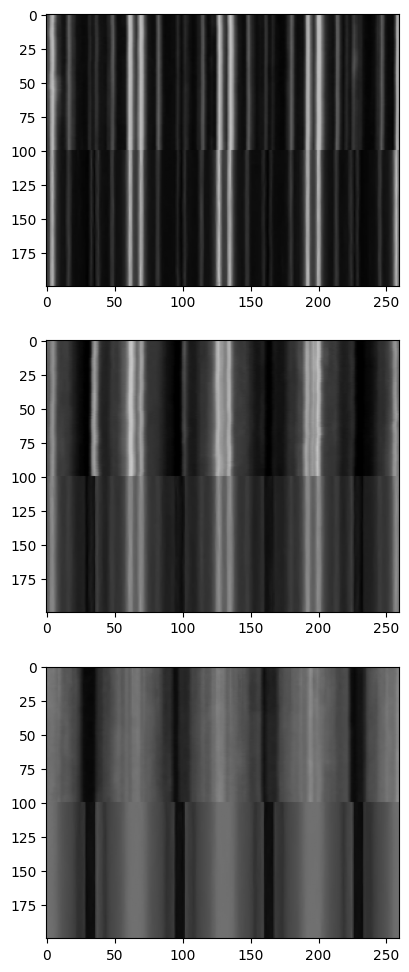

In [16]:
_,axs = plt.subplots(3,1,figsize=(8,12))
imgs_joined = [joined,used_joined,joined_gone]

for ax,img in zip(axs,imgs_joined):
    ax.imshow(img,cmap='gray',vmin=0,vmax=1)